# Introduction to Data Science
## Model assessment

Import all of the packages we will need.

In [7]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

# I've abstracted some of what we'll be doing today into a library.
# You can take a look at this code if you want by going into `dstools/data_tools.py`
# from dstools import data_tools

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

model_types = ["decision_tree", "logistic_regression"]

In [2]:
# Get some data
data = pd.read_csv("data/churn.csv")

data['COLLEGE'] = pd.Series(data['COLLEGE'] == "one", dtype=int)

for field in ['REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN']:
    for value in data[field].unique():
        data[field + "_" + value] = pd.Series(data[field] == value, dtype=int)
    data = data.drop([field], axis=1)

X = data.drop(['LEAVE'], axis=1)
Y = pd.Series(data['LEAVE'] == 'STAY', dtype=int)

### Receiver operating characteristic (ROC) curves
Let's rebuild the type of model we looked at in the previous notebook's group portion. Here were are trying to predict if customers are given a credit card (`Y_handson = 1`) using the three features in `X_handson`: "earning", "geographic", and "experience".

Up until this point we have been using Accuracy (the number of records correctly classified divided by the total number of records). However, we saw that this does not always give us the "best" interpretation of our model's performance. Another way to measure the performance of a model is to use reciever operating characteristic (ROC) curves. Doing this in sklearn is relatively straight forward.

Let's start by dividing our data into training and test sets.

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

We can now build and fit a model. Using this model, we will plot an ROC curve.

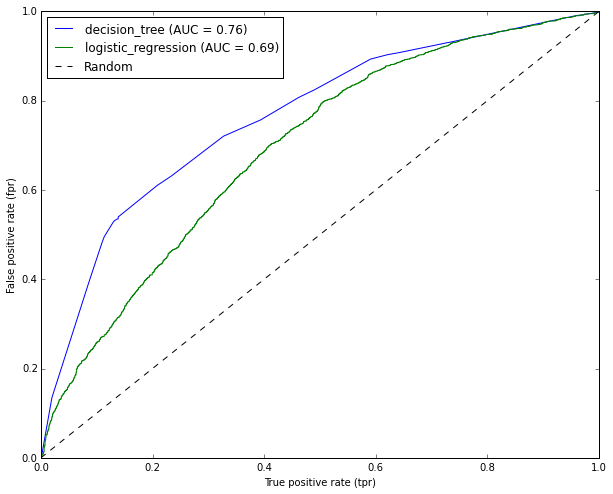

In [8]:
for model_type in model_types:
    # Instantiate the model
    if model_type == "decision_tree":
        model = DecisionTreeClassifier(criterion="entropy", max_depth=5)
    elif model_type == "logistic_regression":
        model = LogisticRegression()
    model.fit(X_train, Y_train)

    # Get the probability of Y_test records being = 1
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
    tpr, fpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability_1)

    # Get the area under the curve (AUC)
    acc = np.mean(cross_validation.cross_val_score(model, X, Y, scoring="accuracy"))
    auc = np.mean(cross_validation.cross_val_score(model, X, Y, scoring="roc_auc"))

    # Plot the ROC curve
    plt.plot(tpr, fpr, label=model_type + " (AUC = " + str(round(auc, 2)) + ")")
plt.xlabel("True positive rate (tpr)")
plt.ylabel("False positive rate (fpr)")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.legend(loc=2)

### Cumulative response and lift curves
The interpretation of an ROC curve may not be entirely intuitive. Let's look at cumulative response curves.

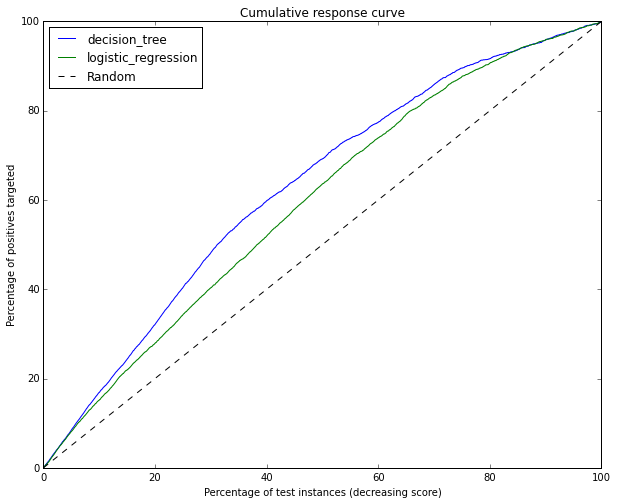

In [15]:
# Keep track of all output
cumulatives_x = {}
cumulatives_y = {}

for model_type in model_types:
    # Instantiate the model
    if model_type == "decision_tree":
        model = DecisionTreeClassifier(criterion="entropy", max_depth=5)
    elif model_type == "logistic_regression":
        model = LogisticRegression()
    model.fit(X_train, Y_train)

    # Get the predicted value and the probability of Y_test records being = 1
    Y_test_predicted = model.predict(X_test)
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Sort these predictions, probabilities, and the true value in descending order of probability
    order = np.argsort(Y_test_probability_1)[::-1]
    Y_test_predicted_sorted = Y_test_predicted[order]
    Y_test_probability_1_sorted = Y_test_probability_1[order]
    Y_test_sorted = np.array(Y_test)[order]

    # Go record-by-record and build the cumulative response curve
    x_cumulative = []
    y_cumulative = []
    total_test_positives = np.sum(Y_test)
    for i in range(1, len(Y_test_probability_1_sorted)+1):
        x_cumulative.append(i)
        y_cumulative.append(np.sum(Y_test_sorted[0:i]) / float(total_test_positives))

    # Rescale
    x_cumulative = np.array(x_cumulative)/float(np.max(x_cumulative)) * 100
    y_cumulative = np.array(y_cumulative) * 100

    cumulatives_x[model_type] = x_cumulative
    cumulatives_y[model_type] = y_cumulative
    
    # Plot
    plt.plot(x_cumulative, y_cumulative, label=model_type)
plt.plot([0,100], [0,100], 'k--', label="Random")
plt.xlabel("Percentage of test instances (decreasing score)")
plt.ylabel("Percentage of positives targeted")
plt.title("Cumulative response curve")
plt.legend(loc=2)
plt.show()

We can also easily look at a lift curve in this scenario.

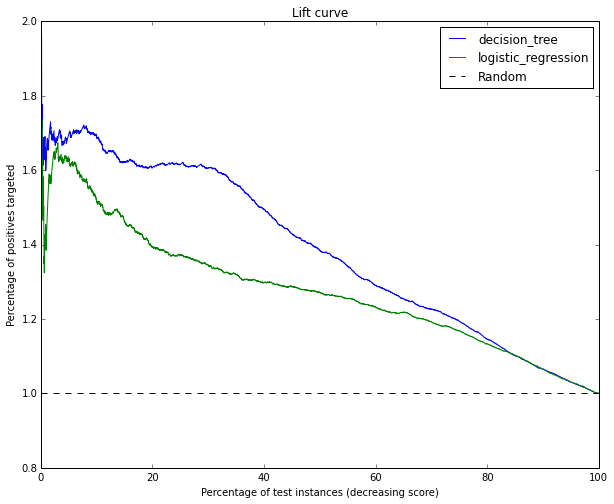

In [12]:
for model_type in model_types:
    x_lift = cumulatives_x[model_type]
    y_lift = cumulatives_y[model_type]/x_lift

    plt.plot(x_lift, y_lift, label=model_type)


plt.plot([0,100], [1,1], 'k--', label="Random")
plt.xlabel("Percentage of test instances (decreasing score)")
plt.ylabel("Percentage of positives targeted")
plt.title("Lift curve")
plt.legend()
plt.show()